In [ ]:
import os

kaggle_dir = '/root/.kaggle'
os.makedirs(kaggle_dir, exist_ok=True)

!cp kaggle.json {kaggle_dir}/
!chmod 600 {kaggle_dir}/kaggle.json


In [ ]:
!kaggle competitions download -c 'visual-taxonomy'

100% 3.52G/3.52G [02:57<00:00, 23.0MB/s]
100% 3.52G/3.52G [02:57<00:00, 21.3MB/s]


In [ ]:
!unzip '*.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train_images/065379.jpg  
  inflating: train_images/065380.jpg  
  inflating: train_images/065381.jpg  
  inflating: train_images/065382.jpg  
  inflating: train_images/065383.jpg  
  inflating: train_images/065384.jpg  
  inflating: train_images/065385.jpg  
  inflating: train_images/065386.jpg  
  inflating: train_images/065387.jpg  
  inflating: train_images/065388.jpg  
  inflating: train_images/065389.jpg  
  inflating: train_images/065390.jpg  
  inflating: train_images/065391.jpg  
  inflating: train_images/065392.jpg  
  inflating: train_images/065393.jpg  
  inflating: train_images/065394.jpg  
  inflating: train_images/065395.jpg  
  inflating: train_images/065396.jpg  
  inflating: train_images/065397.jpg  
  inflating: train_images/065398.jpg  
  inflating: train_images/065399.jpg  
  inflating: train_images/065400.jpg  
  inflating: train_images/065401.jpg  
  inflating: train_images/065402.jpg  
  inflating: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import f1_score
import os
import random
import logging
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
import torch.nn.functional as F

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Previous WeightedFocalLoss class remains the same
class WeightedFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha  # Weight for each class

    def forward(self, pred, true):
        ce_loss = F.cross_entropy(pred, true, reduction='none', weight=self.alpha)
        p_t = torch.exp(-ce_loss)
        loss = (1 - p_t) ** self.gamma * ce_loss
        return loss.mean()

class FashionDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, augment=False):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.augment = augment

        # Create category and attribute mappings
        self.setup_mappings()

        # Calculate class weights for each attribute
        self.calculate_class_weights()

        # Setup augmentation transforms
        self.aug_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1))
        ])

    def setup_mappings(self):
        """Create mappings for categories and their attributes with improved handling"""
        self.category_map = {cat: idx for idx, cat in enumerate(self.data['Category'].unique())}
        self.reverse_category_map = {v: k for k, v in self.category_map.items()}

        self.attr_maps = defaultdict(dict)
        self.attr_counts = defaultdict(dict)
        self.attr_distributions = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

        for category in self.category_map.keys():
            cat_data = self.data[self.data['Category'] == category]
            for i in range(1, 11):
                col = f'attr_{i}'
                if col in cat_data.columns:
                    values = cat_data[col].dropna()
                    if len(values) > 0:
                        unique_values = values.unique()
                        self.attr_maps[category][col] = {val: idx for idx, val in enumerate(unique_values)}
                        self.attr_counts[category][col] = len(unique_values)

                        # Calculate value distributions
                        value_counts = values.value_counts()
                        for val, count in value_counts.items():
                            self.attr_distributions[category][col][val] = count

    def calculate_class_weights(self):
        """Calculate weights for each class in each attribute"""
        self.class_weights = defaultdict(lambda: defaultdict(dict))

        for category in self.attr_distributions:
            for attr in self.attr_distributions[category]:
                dist = self.attr_distributions[category][attr]
                total = sum(dist.values())
                max_count = max(dist.values())

                # Calculate inverse frequency weights with smoothing
                weights = {
                    val: np.sqrt(max_count / count)
                    for val, count in dist.items()
                }

                # Normalize weights
                weight_sum = sum(weights.values())
                weights = {k: v/weight_sum for k, v in weights.items()}

                self.class_weights[category][attr] = weights

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_filename = f"{int(row['id']):06d}.jpg"
        img_path = os.path.join(self.img_dir, img_filename)

        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            logger.error(f"Image not found: {img_path}")
            raise

        # Apply augmentation if enabled
        if self.augment:
            image = self.aug_transform(image)

        if self.transform:
            image = self.transform(image)

        category = row['Category']
        category_label = self.category_map[category]

        # Get attribute labels with improved handling
        attr_labels = {f'attr_{i}': -1 for i in range(1, 11)}
        attr_weights = {f'attr_{i}': 1.0 for i in range(1, 11)}

        if category in self.attr_maps:
            for attr_name, attr_map in self.attr_maps[category].items():
                if pd.notna(row[attr_name]):
                    value = row[attr_name]
                    attr_labels[attr_name] = attr_map.get(value, -1)
                    # Get class weight
                    if value in self.class_weights[category][attr_name]:
                        attr_weights[attr_name] = self.class_weights[category][attr_name][value]

        return image, category_label, attr_labels, attr_weights



class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ImprovedAttributeClassifier(nn.Module):
    def __init__(self, dataset, backbone='resnet50'):
        super().__init__()
        self.dataset = dataset

        # Load and modify backbone
        if backbone == 'resnet50':
            self.backbone = models.resnet50(pretrained=True)
            num_ftrs = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()

            # Freeze and unfreeze layers
            for param in self.backbone.parameters():
                param.requires_grad = False
            for param in self.backbone.layer3.parameters():
                param.requires_grad = True
            for param in self.backbone.layer4.parameters():
                param.requires_grad = True

            # Add SE block
            self.se_block = SEBlock(2048)

            # Attribute classifiers
            self.attribute_heads = nn.ModuleDict()
            for category, attr_counts in dataset.attr_counts.items():
                category_str = str(dataset.category_map[category])
                category_heads = nn.ModuleDict()

                for attr_name, count in attr_counts.items():
                    if self.is_complex_attribute(category, attr_name):
                        category_heads[attr_name] = nn.Sequential(
                            nn.Linear(num_ftrs, 512),
                            nn.GroupNorm(8, 512),
                            nn.ReLU(),
                            nn.Dropout(0.4),
                            nn.Linear(512, 256),
                            nn.GroupNorm(8, 256),
                            nn.ReLU(),
                            nn.Dropout(0.3),
                            nn.Linear(256, count)
                        )
                    else:
                        category_heads[attr_name] = nn.Sequential(
                            nn.Linear(num_ftrs, 256),
                            nn.GroupNorm(8, 256),
                            nn.ReLU(),
                            nn.Dropout(0.3),
                            nn.Linear(256, count)
                        )

                self.attribute_heads[category_str] = category_heads



    def forward(self, x, category):
        # Extract features with attention
        features = self.backbone.conv1(x)
        features = self.backbone.bn1(features)
        features = self.backbone.relu(features)
        features = self.backbone.maxpool(features)

        features = self.backbone.layer1(features)
        features = self.backbone.layer2(features)
        features = self.backbone.layer3(features)
        features = self.backbone.layer4(features)

        # Apply SE block
        features = self.se_block(features)

        # Global average pooling
        features = F.adaptive_avg_pool2d(features, (1, 1))
        features = torch.flatten(features, 1)

        attr_outs = {}
        for idx, cat_idx in enumerate(category):
            cat_str = str(cat_idx.item())
            if cat_str in self.attribute_heads:
                cat_features = features[idx:idx+1]
                attr_outs[idx] = {
                    name: head(cat_features)
                    for name, head in self.attribute_heads[cat_str].items()
                }

        return attr_outs

    # Rest of the class methods remain the same
    def is_complex_attribute(self, category, attr_name):
        """Determine if an attribute needs more complex handling"""
        complex_attributes = {
            'Sarees': {'attr_4', 'attr_7', 'attr_8'},
            'Women Tops & Tunics': {'attr_5', 'attr_10'},
            'Women Tshirts': {'attr_2', 'attr_5'}
        }
        return category in complex_attributes and attr_name in complex_attributes[category]



def validate(model, val_loader, device):
    model.eval()
    predictions = defaultdict(lambda: defaultdict(list))
    ground_truth = defaultdict(lambda: defaultdict(list))

    with torch.no_grad():
        for images, category, attr_labels, _ in tqdm(val_loader, desc="Validating"):
            images = images.to(device)
            category = category.to(device)
            attr_outs = model(images, category)

            for idx, cat_idx in enumerate(category):
                category_name = model.dataset.reverse_category_map[cat_idx.item()]

                if idx in attr_outs:
                    cat_preds = attr_outs[idx]
                    for attr_name, pred in cat_preds.items():
                        if attr_name in attr_labels:
                            true_label = attr_labels[attr_name][idx].item()
                            if true_label != -1:
                                pred_label = torch.argmax(pred, dim=1).cpu().item()
                                predictions[category_name][attr_name].append(pred_label)
                                ground_truth[category_name][attr_name].append(true_label)

    # Calculate scores
    category_scores = {}
    for category in predictions:
        attr_scores = []
        for attr_name in predictions[category]:
            true = ground_truth[category][attr_name]
            pred = predictions[category][attr_name]
            if len(true) > 0:
                micro_f1 = f1_score(true, pred, average='micro')
                macro_f1 = f1_score(true, pred, average='macro')
                if micro_f1 + macro_f1 > 0:
                    attr_f1 = (2 * micro_f1 * macro_f1) / (micro_f1 + macro_f1)
                    attr_scores.append(attr_f1)
        if attr_scores:
            category_scores[category] = np.mean(attr_scores)

    final_score = np.mean(list(category_scores.values()))
    return final_score, category_scores



def main():
    # Set random seeds
    seed = 42
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Using device: {device}")

    # Setup transforms with improved augmentation
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load single dataset and split into train/val
    full_dataset = FashionDataset(csv_file='/content/train.csv', img_dir='/content/train_images',
                                transform=None)


    full_dataset = FashionDataset(csv_file='/content/train.csv', img_dir='/content/train_images', transform=None)

# Calculate split sizes
    total_size = len(full_dataset)
    train_size = int(0.8 * total_size)
    val_size = total_size - train_size

# Create train/val splits
    train_indices, val_indices = torch.utils.data.random_split(
        range(total_size),
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_indices = [int(index) for index in train_indices]
    val_indices = [int(index) for index in val_indices]

# Create train/val datasets with appropriate transforms
    train_dataset = FashionDataset(
        csv_file='/content/train.csv',
        img_dir='/content/train_images',
        transform=train_transform,
        augment=True
    )
    train_dataset.data = train_dataset.data.iloc[train_indices]

    val_dataset = FashionDataset(
        csv_file='/content/train.csv',
        img_dir='/content/train_images',
        transform=val_transform,
        augment=False
    )
    val_dataset.data = val_dataset.data.iloc[val_indices]

    # Calculate split sizes
    total_size = len(full_dataset)
    train_size = int(0.8 * total_size)
    val_size = total_size - train_size

    # Create train/val splits
    train_indices, val_indices = torch.utils.data.random_split(
        range(total_size),
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )


    # Initialize DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    # Initialize model
    model = ImprovedAttributeClassifier(train_dataset).to(device)

    # Training parameters
    criterion = WeightedFocalLoss(gamma=2.0)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)

    # Training loop
    num_epochs = 5
    best_score = 0.0
    patience = 1
    patience_counter = 0

    for epoch in range(num_epochs):
        logger.info(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training
        model.train()
        total_loss = 0
        num_batches = len(train_loader)

        for batch_idx, (images, category, attr_labels, attr_weights) in enumerate(tqdm(train_loader, desc="Training")):
            optimizer.zero_grad()

            try:
                # Move data to device
                images = images.to(device)
                category = category.to(device)

                # Forward pass
                attr_outs = model(images, category)

                # Calculate loss for each sample and attribute
                batch_loss = 0
                valid_predictions = 0

                for idx, cat_idx in enumerate(category):
                    cat_str = str(cat_idx.item())

                    if idx in attr_outs and cat_str in model.attribute_heads:
                        cat_preds = attr_outs[idx]

                        for attr_name, pred in cat_preds.items():
                            true_label = attr_labels[attr_name][idx].item()

                            # Only compute loss for valid labels (-1 indicates missing/invalid label)
                            if true_label != -1:
                                # Ensure pred has correct shape [1, num_classes]
                                if len(pred.shape) == 1:
                                    pred = pred.unsqueeze(0)

                                # Convert true_label to tensor and move to device
                                true_label_tensor = torch.tensor([true_label], device=device)

                                # Get weight for this attribute and class
                                weight = attr_weights[attr_name][idx]
                                weight_tensor = torch.tensor([weight], device=device, dtype=torch.float32)

                                # Calculate weighted focal loss
                                try:
                                    loss = criterion(pred, true_label_tensor)
                                    batch_loss += loss * weight_tensor
                                    valid_predictions += 1
                                except RuntimeError as e:
                                    logger.error(f"Loss calculation failed: {e}")
                                    logger.error(f"Pred shape: {pred.shape}, Label shape: {true_label_tensor.shape}")
                                    raise

                # Normalize loss by number of valid predictions
                if valid_predictions > 0:
                    batch_loss = batch_loss / valid_predictions
                    batch_loss.backward()

                    # Gradient clipping to prevent explosion
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                    optimizer.step()
                    total_loss += batch_loss.item()

                # Print progress
                if (batch_idx + 1) % 100 == 0:
                    avg_loss = total_loss / (batch_idx + 1)
                    logger.info(f"Batch {batch_idx + 1}/{num_batches}, Avg Loss: {avg_loss:.4f}")

            except RuntimeError as e:
                logger.error(f"Error in batch {batch_idx}: {e}")
                continue

        # Update learning rate
        scheduler.step()

        # Validation phase
        model.eval()
        try:
            val_score, category_scores = validate(model, val_loader, device)

            # Log validation results
            logger.info(f"\nValidation Score: {val_score:.4f}")
            logger.info("\nCategory Scores:")
            for category, score in category_scores.items():
                logger.info(f"{category}: {score:.4f}")

            # Save best model
            if val_score > best_score:
                best_score = val_score
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'best_score': best_score,
                    'category_scores': category_scores
                }, 'best_model.pth')
                patience_counter = 0
            else:
                patience_counter += 1

            # Early stopping
            if patience_counter >= patience:
                logger.info(f"\nEarly stopping triggered after {epoch + 1} epochs")
                break

        except Exception as e:
            logger.error(f"Validation failed: {e}")
            continue


def predict(model, image_path, transform, device):
    """
    Make predictions for a single image
    """
    model.eval()

    try:
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        if transform:
            image = transform(image)
        image = image.unsqueeze(0).to(device)

        # Initialize predictions dictionary
        predictions = defaultdict(dict)

        # Make predictions for each category
        with torch.no_grad():
            for category_idx in range(len(model.dataset.category_map)):
                category_tensor = torch.tensor([category_idx], device=device)
                attr_outs = model(image, category_tensor)

                if 0 in attr_outs:  # Check if we have predictions for this category
                    category_name = model.dataset.reverse_category_map[category_idx]
                    category_preds = attr_outs[0]

                    for attr_name, pred in category_preds.items():
                        pred_probs = F.softmax(pred, dim=1)
                        pred_class = torch.argmax(pred_probs, dim=1).item()
                        confidence = pred_probs[0][pred_class].item()

                        # Get original attribute value from mapping
                        attr_map = model.dataset.attr_maps[category_name][attr_name]
                        pred_value = [k for k, v in attr_map.items() if v == pred_class][0]

                        predictions[category_name][attr_name] = {
                            'value': pred_value,
                            'confidence': confidence
                        }

        return predictions

    except Exception as e:
        logger.error(f"Prediction failed: {e}")
        return None

if __name__ == '__main__':
    main()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

In [ ]:
import torch
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm
from torchvision import transforms
import logging
from collections import defaultdict

def load_trained_model(model_path, dataset, device):
    """Load the trained model from checkpoint"""
    model = ImprovedAttributeClassifier(dataset).to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

def predict_test_data(model, test_csv, test_img_dir, batch_size=32, device='cuda'):
    """Generate predictions for test data"""
    # Set up transform for test images
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Read test CSV
    test_df = pd.read_csv(test_csv)
    predictions = []

    # Process in batches
    for idx in tqdm(range(0, len(test_df), batch_size)):
        batch_df = test_df.iloc[idx:idx + batch_size]
        batch_images = []
        batch_categories = []

        # Load batch images
        for _, row in batch_df.iterrows():
            img_path = os.path.join(test_img_dir, f"{int(row['id']):06d}.jpg")
            try:
                image = Image.open(img_path).convert('RGB')
                image = test_transform(image)
                batch_images.append(image)
                batch_categories.append(model.dataset.category_map[row['Category']])
            except Exception as e:
                logging.error(f"Error processing image {img_path}: {e}")
                continue

        if not batch_images:
            continue

        # Convert to tensors
        images = torch.stack(batch_images).to(device)
        categories = torch.tensor(batch_categories).to(device)

        # Get predictions
        with torch.no_grad():
            attr_outs = model(images, categories)

            # Process predictions for each image in batch
            for batch_idx, (_, row) in enumerate(batch_df.iterrows()):
                if batch_idx in attr_outs:
                    category = row['Category']
                    pred_dict = {'id': row['id'], 'Category': category}

                    # Get predictions for each attribute
                    cat_preds = attr_outs[batch_idx]
                    for attr_name, pred in cat_preds.items():
                        pred_probs = torch.softmax(pred, dim=1)
                        pred_class = torch.argmax(pred_probs, dim=1).item()

                        # Get original attribute value from mapping
                        attr_map = model.dataset.attr_maps[category][attr_name]
                        pred_value = [k for k, v in attr_map.items() if v == pred_class][0]

                        pred_dict[attr_name] = pred_value

                    predictions.append(pred_dict)

    # Convert predictions to DataFrame
    predictions_df = pd.DataFrame(predictions)
    return predictions_df

def main():
    # Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logging.basicConfig(level=logging.INFO)

    # Paths
    model_path = 'best_model.pth'
    train_csv = 'train.csv'  # Original training CSV needed for category/attribute mappings
    test_csv = 'test.csv'
    test_img_dir = 'test_images'
    output_csv = 'predictions.csv'

    # Load original dataset to get mappings
    dataset = FashionDataset(
        csv_file=train_csv,
        img_dir='train_images',  # This won't be used for prediction
        transform=None
    )

    # Load model
    logging.info("Loading model...")
    model = load_trained_model(model_path, dataset, device)

    # Generate predictions
    logging.info("Generating predictions...")
    predictions_df = predict_test_data(model, test_csv, test_img_dir, device=device)

    # Save predictions
    logging.info("Saving predictions...")
    predictions_df.to_csv(output_csv, index=False)
    logging.info(f"Predictions saved to {output_csv}")

if __name__ == '__main__':
    main()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-5-618d8d9566cb>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detail

In [ ]:
import pandas as pd
from google.colab import files

def process_csv(df):
    # Dictionary mapping categories to their lengths
    category_lengths = {
        'Sarees': 10,
        'Women Tops & Tunics': 10,
        'Women Tshirts': 8,
        'Men Tshirts': 5,
        'Kurtis': 1
    }

    # Add the len column based on Category
    df['len'] = df['Category'].map(category_lengths)

    # Reorder columns to put 'len' as the third column
    cols = df.columns.tolist()
    cols.remove('len')
    new_cols = cols[:2] + ['len'] + cols[2:]
    df = df[new_cols]

    # Get all attribute columns
    attr_columns = [col for col in df.columns if col.startswith('attr_')]

    # Function to fill dummy values based on category length
    def fill_dummy_values(row):
        category_len = row['len']
        for i, col in enumerate(attr_columns, 1):
            if i > category_len and pd.isna(row[col]):
                row[col] = 'dummy_value'
        return row

    # Apply the function to each row
    df = df.apply(fill_dummy_values, axis=1)

    return df

# Example usage
# Read the CSV
df = pd.read_csv('/content/predictions.csv')

# Process the DataFrame
processed_df = process_csv(df)

# Save the processed DataFrame
processed_df.to_csv('processed_output.csv', index=False)

files.download('processed_output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-8-b8a6d019f4e4>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detail

Final F1 Score: 0.7953142944287258
Category-wise F1 Scores: {'Men Tshirts': 0.9049331328831591, 'Sarees': 0.6387463388390524, 'Kurtis': 0.8510723790414924, 'Women Tshirts': 0.8037227773974591, 'Women Tops & Tunics': 0.7780968439824656}


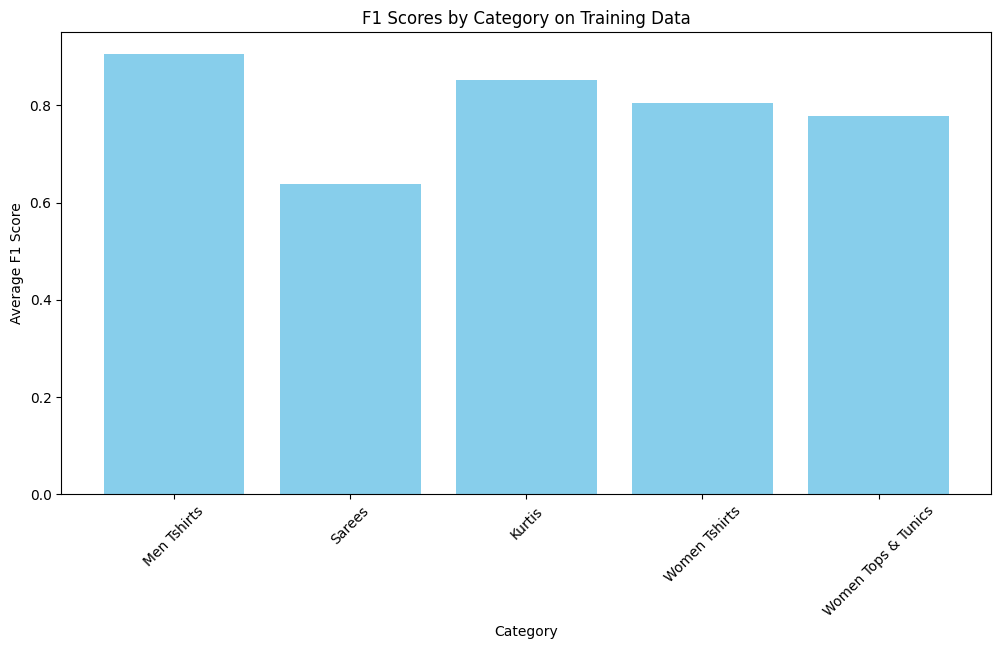

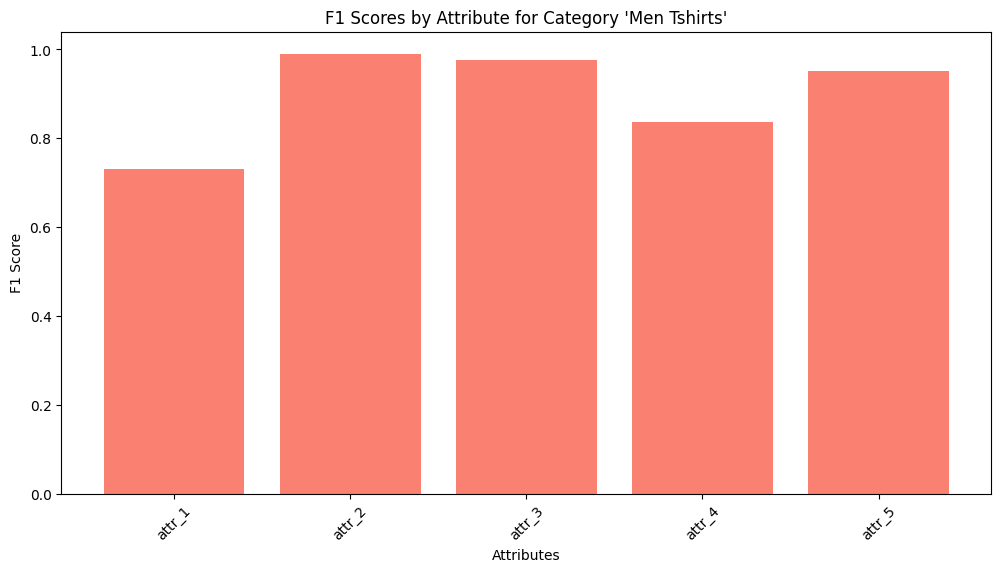

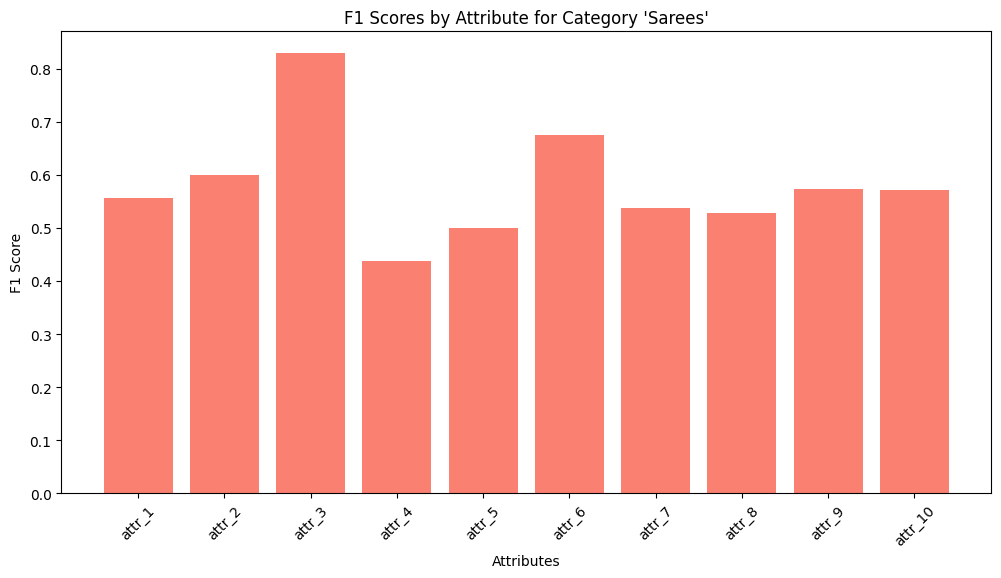

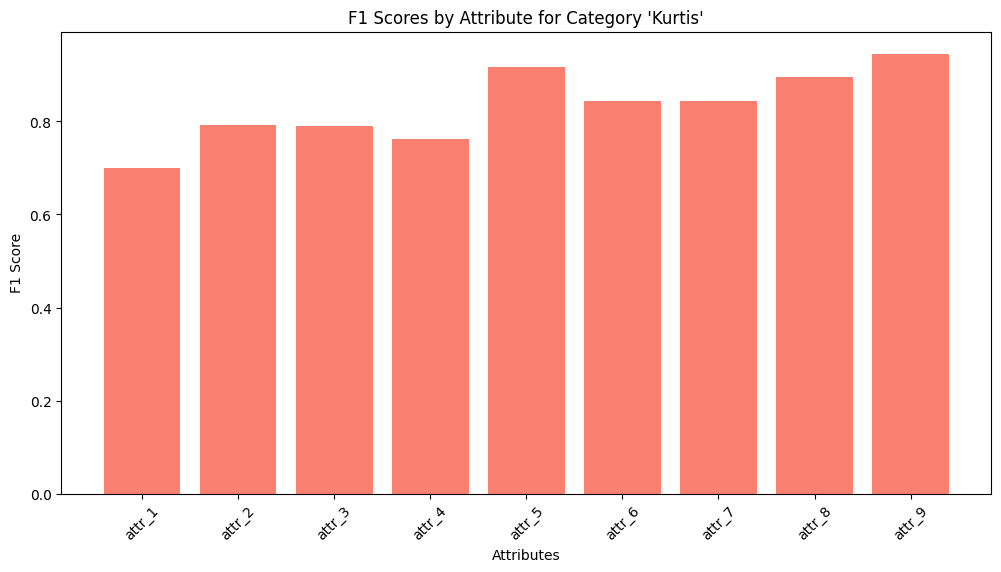

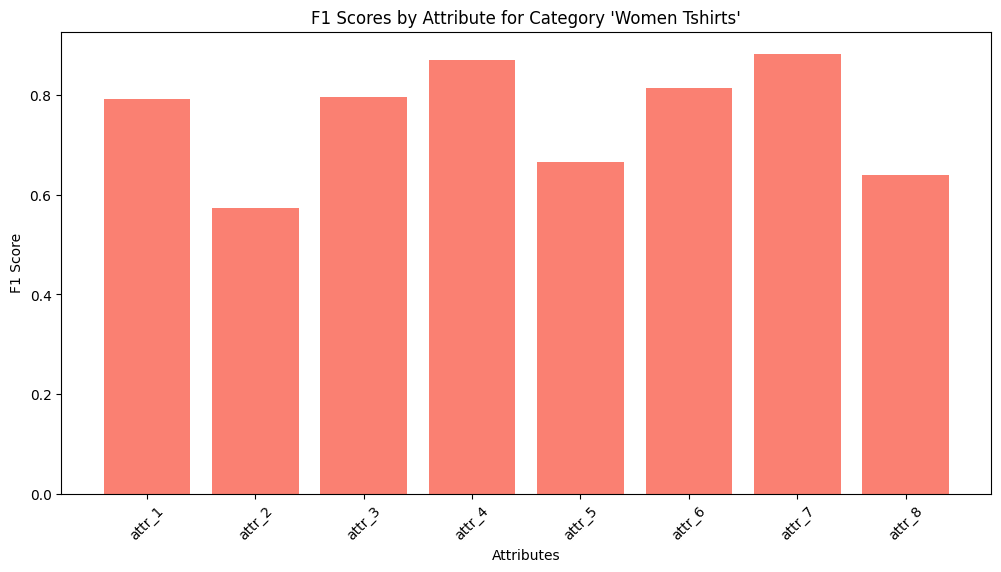

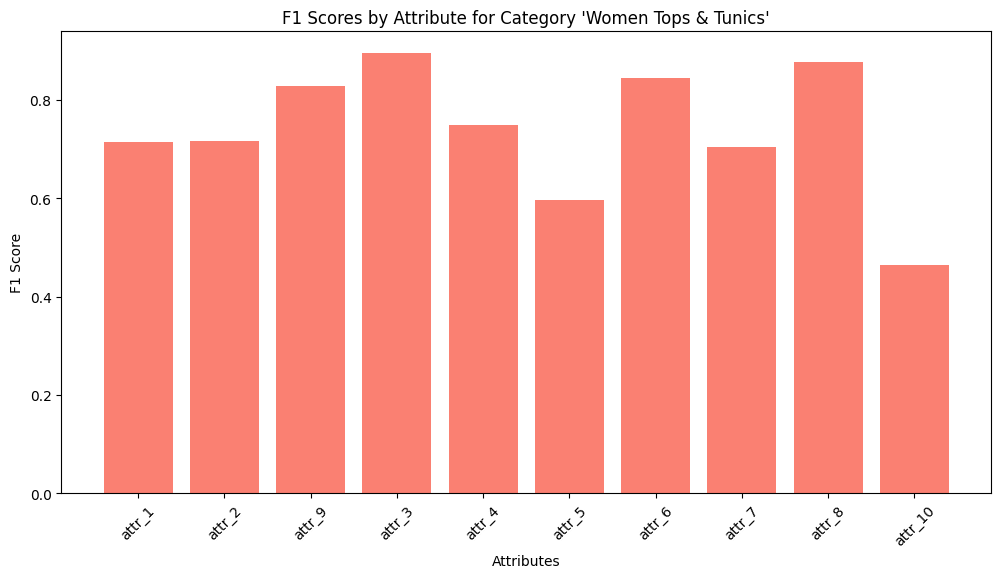

In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = FashionDataset(csv_file='/content/train.csv', img_dir='/content/train_images', transform=train_transform)

# Load the best model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedAttributeClassifier(train_dataset)  # Replace 'full_dataset' with the actual dataset object
state_dict = torch.load('/content/best_model.pth', map_location=device)
filtered_state_dict = {k: v for k, v in state_dict['model_state_dict'].items()
                        if k in model.state_dict()}
model.load_state_dict(filtered_state_dict, strict=False)
model.to(device)
model.eval()

# Load train data for evaluation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = FashionDataset(csv_file='/content/train.csv', img_dir='/content/train_images', transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Validation function to get predictions and ground truth
def evaluate(model, data_loader):
    predictions = defaultdict(lambda: defaultdict(list))
    ground_truth = defaultdict(lambda: defaultdict(list))

    with torch.no_grad():
        for images, category, attr_labels, _ in tqdm(data_loader, desc="Evaluating on Training Data"):
            images = images.to(device)
            category = category.to(device)
            attr_outs = model(images, category)

            for idx, cat_idx in enumerate(category):
                category_name = model.dataset.reverse_category_map[cat_idx.item()]

                if idx in attr_outs:
                    cat_preds = attr_outs[idx]
                    for attr_name, pred in cat_preds.items():
                        if attr_name in attr_labels:
                            true_label = attr_labels[attr_name][idx].item()
                            if true_label != -1:
                                pred_label = torch.argmax(pred, dim=1).cpu().item()
                                predictions[category_name][attr_name].append(pred_label)
                                ground_truth[category_name][attr_name].append(true_label)

    # Calculate F1 scores
    category_scores = {}
    for category in predictions:
        attr_scores = []
        for attr_name in predictions[category]:
            true = ground_truth[category][attr_name]
            pred = predictions[category][attr_name]
            if len(true) > 0:
                micro_f1 = f1_score(true, pred, average='micro')
                macro_f1 = f1_score(true, pred, average='macro')
                if micro_f1 + macro_f1 > 0:
                    attr_f1 = (2 * micro_f1 * macro_f1) / (micro_f1 + macro_f1)
                    attr_scores.append(attr_f1)
        if attr_scores:
            category_scores[category] = np.mean(attr_scores)

    final_score = np.mean(list(category_scores.values()))
    return final_score, category_scores , predictions, ground_truth

# Evaluate and get scores
final_score, category_scores, predictions, ground_truth = evaluate(model, train_loader)
print("Final F1 Score:", final_score)
print("Category-wise F1 Scores:", category_scores)

# Plot the F1 scores by category
plt.figure(figsize=(12, 6))
plt.bar(category_scores.keys(), category_scores.values(), color='skyblue')
plt.xlabel("Category")
plt.ylabel("Average F1 Score")
plt.title("F1 Scores by Category on Training Data")
plt.xticks(rotation=45)
plt.show()

# Optional: Detailed attribute-wise F1 score plots for each category
for category in category_scores:
    attr_names = list(predictions[category].keys())
    attr_f1_scores = [f1_score(ground_truth[category][attr], predictions[category][attr], average='macro')
                      for attr in attr_names]

    plt.figure(figsize=(12, 6))
    plt.bar(attr_names, attr_f1_scores, color='salmon')
    plt.xlabel("Attributes")
    plt.ylabel("F1 Score")
    plt.title(f"F1 Scores by Attribute for Category '{category}'")
    plt.xticks(rotation=45)
    plt.show()
